In [1]:
import os
import inspect
import time
import warnings
import calendar

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

# Silence warnings to keep output clean
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("loan.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           887379 non-null  int64  
 1   member_id                    887379 non-null  int64  
 2   loan_amnt                    887379 non-null  float64
 3   funded_amnt                  887379 non-null  float64
 4   funded_amnt_inv              887379 non-null  float64
 5   term                         887379 non-null  object 
 6   int_rate                     887379 non-null  float64
 7   installment                  887379 non-null  float64
 8   grade                        887379 non-null  object 
 9   sub_grade                    887379 non-null  object 
 10  emp_title                    835917 non-null  object 
 11  emp_length                   842554 non-null  object 
 12  home_ownership               887379 non-null  object 
 13 

In [6]:
df.isnull().sum()

id                       0
member_id                0
loan_amnt                0
funded_amnt              0
funded_amnt_inv          0
                     ...  
all_util            866007
total_rev_hi_lim     70276
inq_fi              866007
total_cu_tl         866007
inq_last_12m        866007
Length: 74, dtype: int64

In [7]:
print("Duplicate Rows:", df.duplicated().sum())

Duplicate Rows: 0


In [8]:
df.nunique()

id                  887379
member_id           887379
loan_amnt             1372
funded_amnt           1372
funded_amnt_inv       9856
                     ...  
all_util              1128
total_rev_hi_lim     21251
inq_fi                  18
total_cu_tl             33
inq_last_12m            29
Length: 74, dtype: int64

In [9]:
# Explore unique values in loan_status
df['loan_status'].value_counts(dropna=False)

loan_status
Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: count, dtype: int64

In [10]:
def map_loan_status(x):
    if x in ['Charged Off', 'Default', 'Late (31-120 days)', 'Late (16-30 days)', 'Does not meet the credit policy. Status:Charged Off']:
        return 1   # BAD borrower
    elif x in ['Fully Paid', 'Current', 'Does not meet the credit policy. Status:Fully Paid']:
        return 0   # GOOD borrower
    else:
        return None  # Exclude these

In [11]:
df['target'] = df['loan_status'].apply(map_loan_status)
df = df.dropna(subset=['target'])  # Remove rows without a clear target
df['target'] = df['target'].astype(int)


# Count and percentage distribution
class_counts = df['target'].value_counts()
class_percent = df['target'].value_counts(normalize=True) * 100

# Display as table
balance_df = pd.DataFrame({
    'Count': class_counts,
    'Percentage': class_percent.round(2)
}).rename(index={0: 'Good (0)', 1: 'Bad (1)'})

print("Class Balance:")
print(balance_df)

Class Balance:
           Count  Percentage
target                      
Good (0)  811490       92.99
Bad (1)    61176        7.01


Highly imbalace data set - typical credit risk situations

In [12]:
#Dropping sparsely populated and not useful columns
drop_cols = [
    'id', 'member_id', 'loan_status', 'url', 'desc', 'title', 'zip_code',
    'policy_code', 'next_pymnt_d', 'last_pymnt_d', 'last_credit_pull_d',
    'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'emp_title',
    'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
    'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
    'recoveries', 'collection_recovery_fee', 'mths_since_last_major_derog'
]

df = df.drop(columns=drop_cols)


#High-Cardinality Categorical & Timestamp Columns - Can cause problem
# Group Categorical Columns by Uniqueness
def group_columns_by_uniques(df):
    unique_counts = df.nunique().sort_values()
cat_cols = df.select_dtypes(include='object').columns
cat_uniques = df[cat_cols].nunique().sort_values()


for n_unique in sorted(cat_uniques.unique()):
    cols_in_group = cat_uniques[cat_uniques == n_unique].index.tolist()
    print(f"\nColumns with {n_unique} unique values:")
    for col in cols_in_group:
        print(f"  - {col}")


Columns with 2 unique values:
  - term
  - pymnt_plan
  - application_type
  - initial_list_status

Columns with 3 unique values:
  - verification_status

Columns with 6 unique values:
  - home_ownership

Columns with 7 unique values:
  - grade

Columns with 11 unique values:
  - emp_length

Columns with 14 unique values:
  - purpose

Columns with 35 unique values:
  - sub_grade

Columns with 51 unique values:
  - addr_state

Columns with 103 unique values:
  - issue_d

Columns with 697 unique values:
  - earliest_cr_line


In [13]:
# Examine & Convert Date Features
print("Sample values of issue_d:")
print(df['issue_d'].dropna().unique()[:10])

print("\nSample values of earliest_cr_line:")
print(df['earliest_cr_line'].dropna().unique()[:10])

Sample values of issue_d:
['Dec-2011' 'Nov-2011' 'Oct-2011' 'Sep-2011' 'Aug-2011' 'Jul-2011'
 'Jun-2011' 'May-2011' 'Apr-2011' 'Mar-2011']

Sample values of earliest_cr_line:
['Jan-1985' 'Apr-1999' 'Nov-2001' 'Feb-1996' 'Jan-1996' 'Nov-2004'
 'Jul-2005' 'Jan-2007' 'Apr-2004' 'Sep-2004']


In [14]:
# Convert to datetime
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce')
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y', errors='coerce')

# Create credit history length (in years)
df['credit_history_length'] = (df['issue_d'] - df['earliest_cr_line']).dt.days / 365

# Drop all date columns
df = df.drop(columns=['issue_d', 'earliest_cr_line'])

In [15]:
#Let us find out missing data percentage
missing_report = df.isnull().mean() * 100
missing_report = missing_report[missing_report > 0].sort_values(ascending=False)
print(missing_report)

il_util                       98.669709
mths_since_rcnt_il            98.517875
inq_fi                        98.477310
all_util                      98.477310
total_cu_tl                   98.477310
inq_last_12m                  98.477310
open_rv_12m                   98.477310
total_bal_il                  98.477310
open_il_12m                   98.477310
open_il_24m                   98.477310
open_il_6m                    98.477310
open_acc_6m                   98.477310
max_bal_bc                    98.477310
open_rv_24m                   98.477310
mths_since_last_record        84.593533
mths_since_last_delinq        51.285944
tot_coll_amt                   8.045461
tot_cur_bal                    8.045461
total_rev_hi_lim               8.045461
emp_length                     5.036979
revol_util                     0.056952
collections_12_mths_ex_med     0.016616
delinq_2yrs                    0.003323
acc_now_delinq                 0.003323
pub_rec                        0.003323


In [16]:
# Drop Heavily Missing Features
drop_heavy_missing = [
    'il_util', 'mths_since_rcnt_il', 'total_bal_il', 'open_il_24m',
    'open_il_12m', 'open_acc_6m', 'open_rv_12m', 'open_rv_24m',
    'open_il_6m', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'max_bal_bc'
]

df = df.drop(columns=drop_heavy_missing)

# Impute Remaining Missing Features
impute_ok = [
    'total_rev_hi_lim', 'tot_coll_amt', 'tot_cur_bal', 'emp_length',
    'revol_util', 'collections_12_mths_ex_med', 'acc_now_delinq',
    'total_acc', 'pub_rec', 'open_acc', 'inq_last_6mths',
    'delinq_2yrs', 'credit_history_length', 'annual_inc',
    'mths_since_last_record', 'mths_since_last_delinq'  
]

In [17]:
# Numerical columns in impute_ok (excluding 'emp_length' which is object)
numerical_to_impute = [col for col in impute_ok if col != 'emp_length']

for col in numerical_to_impute:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)
    print(f"Filled missing values in numerical column: {col} with median: {median_val}")

# emp_length is categorical → use mode
mode_val = df['emp_length'].mode()[0]
df['emp_length'] = df['emp_length'].fillna(mode_val)
print(f"Filled missing values in categorical column: emp_length with mode: {mode_val}")

Filled missing values in numerical column: total_rev_hi_lim with median: 23700.0
Filled missing values in numerical column: tot_coll_amt with median: 0.0
Filled missing values in numerical column: tot_cur_bal with median: 80603.0
Filled missing values in numerical column: revol_util with median: 56.0
Filled missing values in numerical column: collections_12_mths_ex_med with median: 0.0
Filled missing values in numerical column: acc_now_delinq with median: 0.0
Filled missing values in numerical column: total_acc with median: 24.0
Filled missing values in numerical column: pub_rec with median: 0.0
Filled missing values in numerical column: open_acc with median: 11.0
Filled missing values in numerical column: inq_last_6mths with median: 0.0
Filled missing values in numerical column: delinq_2yrs with median: 0.0
Filled missing values in numerical column: credit_history_length with median: 14.846575342465753
Filled missing values in numerical column: annual_inc with median: 64800.0
Filled m

loanburden = loan amount / (annual income +1)
Weight of Evidence (WoE) = ln([Distribution of good in bin i]/[Distribution of bad in bin i]) 
Information Value (IV) = Sum (Dist. of Good in i-th bin - Dist. of Bad in i-th bin) * WoE

In [18]:
df['loan_burden'] = df['loan_amnt'] / (df['annual_inc'] + 1)
df = df.drop(columns=['loan_amnt', 'dti'])

In [19]:
#Binning data - Entropy binning
def decision_tree_binning(X, y, max_leaf_nodes=5):
    X_reshaped = X.values.reshape(-1, 1)
    tree = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=max_leaf_nodes, min_samples_leaf=0.05)
    tree.fit(X_reshaped, y)

    thresholds = tree.tree_.threshold
    thresholds = thresholds[thresholds != -2]  # -2 = leaf node

    bins = [-np.inf] + sorted(thresholds.tolist()) + [np.inf]
    return bins

# List of numerical features to bin
features_to_bin = [
    'annual_inc', 'int_rate',
    'credit_history_length', 'total_rev_hi_lim',
    'open_acc', 'revol_util', 'tot_cur_bal', 'mths_since_last_record', 'mths_since_last_delinq',
    'loan_burden'
]

# Tree-bin each feature
for feature in features_to_bin:
    try:
        bins = decision_tree_binning(df[feature], df['target'])
        df[feature + '_bin'] = pd.cut(df[feature], bins=bins)
        print(f"Binned {feature} into {len(bins)-1} tree-based bins.")
    except Exception as e:
        print(f"Could not bin {feature}: {e}")


#WoE and IV
def calc_woe_iv(df, feature_bin_col, target_col='target'):
    grouped = df.groupby(feature_bin_col)[target_col].agg(['count', 'sum'])
    grouped.columns = ['total', 'bad']
    grouped['good'] = grouped['total'] - grouped['bad']
    
    dist_good = grouped['good'] / grouped['good'].sum()
    dist_bad = grouped['bad'] / grouped['bad'].sum()
    
    grouped['woe'] = np.log((dist_good + 1e-6) / (dist_bad + 1e-6))
    grouped['iv'] = (dist_good - dist_bad) * grouped['woe']
    
    woe_dict = grouped['woe'].to_dict()
    iv_score = grouped['iv'].sum()
    
    return woe_dict, iv_score        

Binned annual_inc into 5 tree-based bins.
Binned int_rate into 5 tree-based bins.
Binned credit_history_length into 5 tree-based bins.
Binned total_rev_hi_lim into 5 tree-based bins.
Binned open_acc into 5 tree-based bins.
Binned revol_util into 5 tree-based bins.
Binned tot_cur_bal into 5 tree-based bins.
Binned mths_since_last_record into 3 tree-based bins.
Binned mths_since_last_delinq into 5 tree-based bins.
Binned loan_burden into 5 tree-based bins.


In [20]:
# Define categorical features for WOE encode
categorical_features = [
    'term',               # 2 values
    'home_ownership',     # 6 values
    'purpose',            # 14 values
    'emp_length',         # 11 values (already imputed)
    'verification_status' # 3 values (optional but simple)
]

In [21]:
woe_iv_summary = []

#Apply WOE to binned numerical features
for feature in features_to_bin:
    bin_col = feature + '_bin'
    try:
        woe_map, iv_score = calc_woe_iv(df, bin_col, 'target')
        df[feature + '_woe'] = df[bin_col].map(woe_map)
        woe_iv_summary.append({'feature': feature, 'iv': iv_score})
        print(f"WOE applied to numerical feature: {feature}, IV = {iv_score:.4f}")
    except Exception as e:
        print(f"Failed WOE on numerical feature: {feature} — {e}")

#Apply WOE to categorical features
for cat_feature in categorical_features:
    try:
        woe_map, iv_score = calc_woe_iv(df, cat_feature, 'target')
        df[cat_feature + '_woe'] = df[cat_feature].map(woe_map)
        woe_iv_summary.append({'feature': cat_feature, 'iv': iv_score})
        print(f"WOE applied to categorical feature: {cat_feature}, IV = {iv_score:.4f}")
    except Exception as e:
        print(f"Failed WOE on categorical feature: {cat_feature} — {e}")

WOE applied to numerical feature: annual_inc, IV = 0.0539
WOE applied to numerical feature: int_rate, IV = 0.5026
WOE applied to numerical feature: credit_history_length, IV = 0.0447
WOE applied to numerical feature: total_rev_hi_lim, IV = 0.1483
WOE applied to numerical feature: open_acc, IV = 0.0052
WOE applied to numerical feature: revol_util, IV = 0.0353
WOE applied to numerical feature: tot_cur_bal, IV = 0.1340
WOE applied to numerical feature: mths_since_last_record, IV = 0.0111
WOE applied to numerical feature: mths_since_last_delinq, IV = 0.0023
WOE applied to numerical feature: loan_burden, IV = 0.0470
WOE applied to categorical feature: term, IV = 0.0212
WOE applied to categorical feature: home_ownership, IV = 0.0222
WOE applied to categorical feature: purpose, IV = 0.0497
WOE applied to categorical feature: emp_length, IV = 0.0067
WOE applied to categorical feature: verification_status, IV = 0.0352


In [22]:
final_woe_features = [
    'int_rate_woe',
    'total_rev_hi_lim_woe',
    'tot_cur_bal_woe',
    'annual_inc_woe',
    'purpose_woe',
    'loan_burden_woe',
    'credit_history_length_woe',
    'revol_util_woe',
    'verification_status_woe'
]

# Drop due to low IV 
drop_woe_cols = [
    'open_acc_woe',
    'mths_since_last_record_woe', 'mths_since_last_delinq_woe',
    'home_ownership_woe', 'term_woe', 'emp_length_woe'
]
df = df.drop(columns=drop_woe_cols)

In [23]:
%%time
#We will strtify our data to take care of imbalance in Logit regression model

X_train, X_test, y_train, y_test = train_test_split(
    df[final_woe_features], df['target'], test_size=0.3, random_state=42, stratify=df['target']) 

model = LogisticRegression()
model.fit(X_train, y_train)

CPU times: total: 1.61 s
Wall time: 1.12 s


LogisticRegression()

In [24]:
y_pred_test = model.predict_proba(X_test)[:, 1]

# View Model Coefficients
#A negative coefficient ---> higher WOE (i.e., less risk) ---> lower default odds.
#Larger magnitude = stronger influence on risk.
coefficients = model.coef_[0]
intercept = model.intercept_[0]

print("\n Coefficients (aligned with features):")
for f, c in zip(final_woe_features, coefficients):
    print(f"  {f:<30} → {c:.4f}")


 Coefficients (aligned with features):
  int_rate_woe                   → -0.9408
  total_rev_hi_lim_woe           → -0.3205
  tot_cur_bal_woe                → -0.7007
  annual_inc_woe                 → -0.3510
  purpose_woe                    → -0.3149
  loan_burden_woe                → -0.2248
  credit_history_length_woe      → -0.3048
  revol_util_woe                 → -0.2110
  verification_status_woe        → -0.3721


In [25]:
auc_test = roc_auc_score(y_test, y_pred_test)
print(f"\n Test AUC: {auc_test:.4f}")


 Test AUC: 0.7188


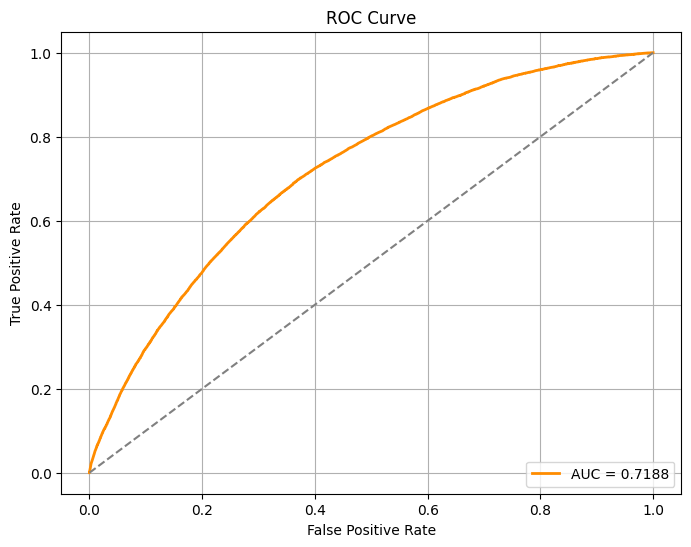

In [26]:
fpr, tpr, _ = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [27]:
# Kolmogorov–Smirnov (KS) Statistic = max separation between TPR and FPR.
ks = max(tpr - fpr)
print(f"KS Statistic: {ks:.4f}")

KS Statistic: 0.3280


In [28]:
#Scaling credit score

# Define X again using final WOE features
X = df[final_woe_features]

# Define Parameters for Score Scaling
PDO = 20           # Points to Double the Odds
BaseScore = 600    # Score assigned to base odds
BaseOdds = 50      # Base odds = Good : Bad = 50:1

# Convert Logistic Output to Score
# Score = Offset – Factor × log-odds
Factor = PDO / np.log(2)
Offset = BaseScore - Factor * np.log(BaseOdds)

log_odds = model.intercept_ + np.dot(X, model.coef_.T).reshape(-1)
df['score'] = Offset - Factor * log_odds

df[['score', 'target']].head()

,score,target
0,543.193447,0
1,526.794081,1
2,512.728053,0
3,544.411774,0
4,545.942425,0


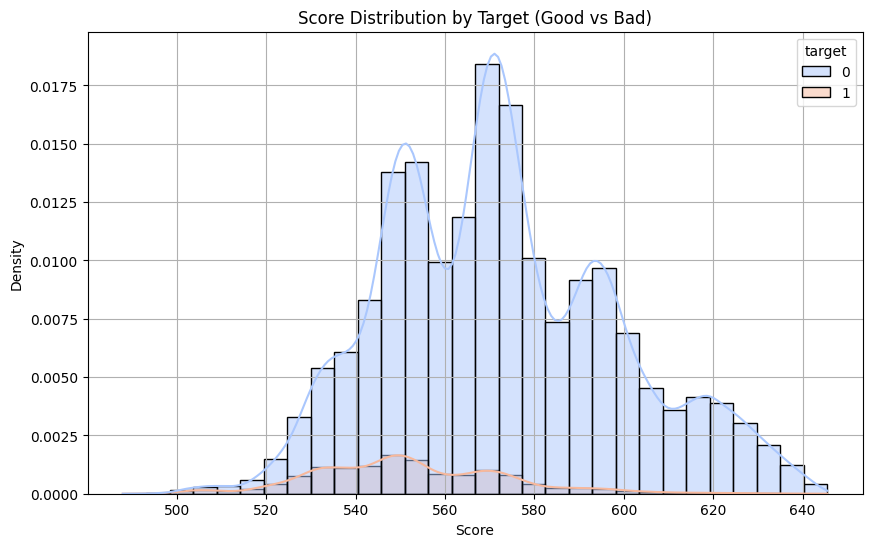

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='score', hue='target', bins=30, kde=True, palette='coolwarm', stat='density')
plt.title('Score Distribution by Target (Good vs Bad)')
plt.xlabel('Score')
plt.ylabel('Density')
plt.grid(True)
plt.show()

We will be mapping between each bin of a variable and its corresponding contribution via a scoring.

Scoring = (-model coefficient for a feature) * WoE * (scaling Factor for Points toward Double the Odds)


In [30]:
Factor = 20 / np.log(2)  # scaling factor ≈ 28.85

scorecard_rows = []

for feature, coef in zip(final_woe_features, model.coef_[0]):
    base_feature = feature.replace('_woe', '')
    
    # If it's a binned feature, use the bin column
    if base_feature + '_bin' in df.columns:
        group_col = base_feature + '_bin'
    else:
        group_col = base_feature  # categorical feature

    try:
        grouped = df.groupby(group_col)['target'].agg(['count', 'sum'])
        grouped.columns = ['total', 'bad']
        grouped['good'] = grouped['total'] - grouped['bad']

        dist_good = grouped['good'] / grouped['good'].sum()
        dist_bad = grouped['bad'] / grouped['bad'].sum()
        grouped['woe'] = np.log((dist_good + 1e-6) / (dist_bad + 1e-6))

        for bin_label, row in grouped.iterrows():
            woe = row['woe']
            points = -coef * woe * Factor
            scorecard_rows.append({
                'feature': base_feature,
                'bin': str(bin_label),
                'woe': round(woe, 4),
                'coefficient': round(coef, 4),
                'points': round(points, 2)
            })
    
    except Exception as e:
        print(f"Error processing {base_feature}: {e}")

# Final scorecard as DataFrame
scorecard_df = pd.DataFrame(scorecard_rows).sort_values(by=['feature', 'bin'])

print(scorecard_df)

                  feature                    bin     woe  coefficient  points
15             annual_inc        (-inf, 43202.0] -0.2922      -0.3510   -2.96
19             annual_inc        (100129.0, inf]  0.3962      -0.3510    4.01
16             annual_inc     (43202.0, 66100.5] -0.0839      -0.3510   -0.85
17             annual_inc   (66100.5, 80046.219]  0.0909      -0.3510    0.92
18             annual_inc  (80046.219, 100129.0]  0.2157      -0.3510    2.19
39  credit_history_length          (-inf, 7.336] -0.4267      -0.3048   -3.75
41  credit_history_length       (13.593, 19.092]  0.0574      -0.3048    0.50
42  credit_history_length       (19.092, 24.768]  0.2339      -0.3048    2.06
43  credit_history_length          (24.768, inf]  0.3328      -0.3048    2.93
40  credit_history_length        (7.336, 13.593] -0.1416      -0.3048   -1.24
0                int_rate          (-inf, 7.275]  1.8652      -0.9408   50.64
3                int_rate         (14.03, 18.58] -0.3812      -0

Each row in the scorecard ddetails contribution and the range of a specific feature. WoE direct link to the credit risk. Coefficient is the weight of the feature in Logit regression. Points directly predicts default risk; Positive - Good, Negative - default risk